In [30]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [2]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC lmc data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&
                (lmc['M_H_ERR']>-90.0)&(lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

In [3]:
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

In [4]:
np.median(np.unique(parsec['MH']))

-1.0655000000000001

# Initial MCMC Fit

In [64]:
# ### AGB Cut
# left = parsec[np.where(parsec['MH']==min(parsec['MH']))]
# middle = parsec[np.where(parsec['MH']==-1.115)]
# right = parsec[np.where(parsec['MH']==max(parsec['MH']))]

# gravs = [min(left['logg'])-0.03,min(middle['logg']),min(right['logg'])-0.015]

# teffs = [max(10**left[np.where(left['logg']==min(left['logg']))]['logTe']),
#          min(10**middle[np.where(middle['logg']==min(middle['logg']))]['logTe']),
#          min(10**right[np.where(right['logg']==min(right['logg']))]['logTe'])]

# zagb = np.polyfit(teffs, gravs, 3)
# pagb = np.poly1d(zagb)

# agb_cut = np.where(lmc['LOGG']>pagb(lmc['TEFF']))

# ### Bloop Cut
# kmags = [0.7,1.]
# colos = [13.5,12.]

# zbloop = np.polyfit(kmags, colos, 1)
# pbloop = np.poly1d(zbloop)

# bloop_cut = np.where(lmc[agb_cut]['K']>pbloop(lmc[agb_cut]['J']-lmc[agb_cut]['K'])+0.1)

# lmc_nobloop_noagb = lmc[agb_cut][bloop_cut]

agb_cut = np.where((lmc['LOGG']>0.125)&(lmc['K']>12.25))

### Bloop Cut
kmags = [0.7,1.]
colos = [13.5,12.]

zbloop = np.polyfit(kmags, colos, 1)
pbloop = np.poly1d(zbloop)

bloop_cut = np.where(lmc[agb_cut]['K']>pbloop(lmc[agb_cut]['J']-lmc[agb_cut]['K'])+0.1)

lmc_nobloop_noagb = lmc[agb_cut][bloop_cut]

In [33]:
# plt.figure(figsize=[10,10])
# plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'])
# plt.colorbar()
# # plt.scatter(10**parsecall[agb]['logTe'],parsecall['logg'][agb],c=parsecall['MH'][agb])
# plt.scatter(lmc['TEFF'],lmc['logg'],c=lmc['K'],vmin=min(lmc['K']),cmap='nipy_spectral')
# plt.colorbar()

# plt.plot([2970,4900],[pagb(2970),pagb(4900)])
# # plt.axhline(12.5,c='k')

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

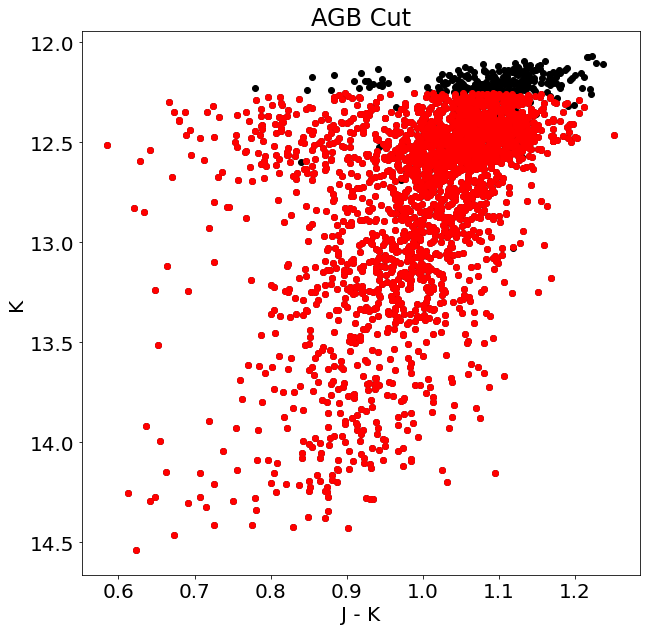

In [65]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.scatter((lmc['J']-lmc['K'])[agb_cut],lmc['K'][agb_cut],c='r')
# plt.axhline(12.5,c='k')

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'AGB Cut')

plt.show()

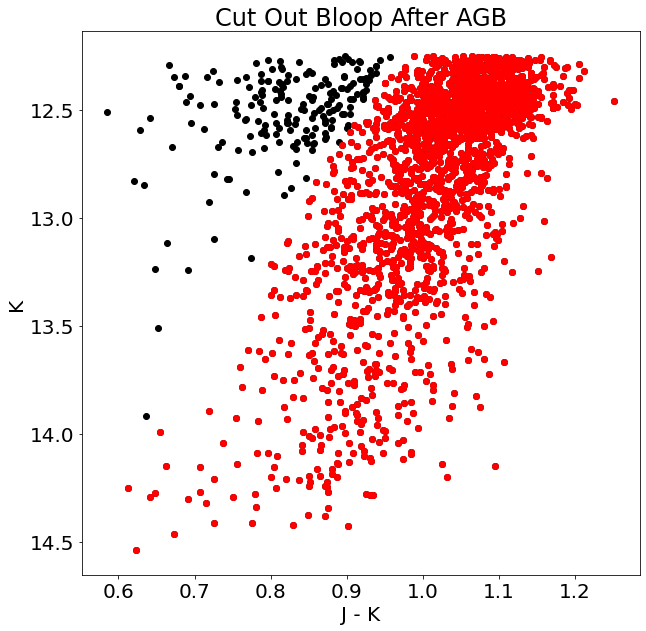

In [66]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K'])[agb_cut],lmc['K'][agb_cut],c='k')
plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r')

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Cut Out Bloop After AGB')

plt.show()

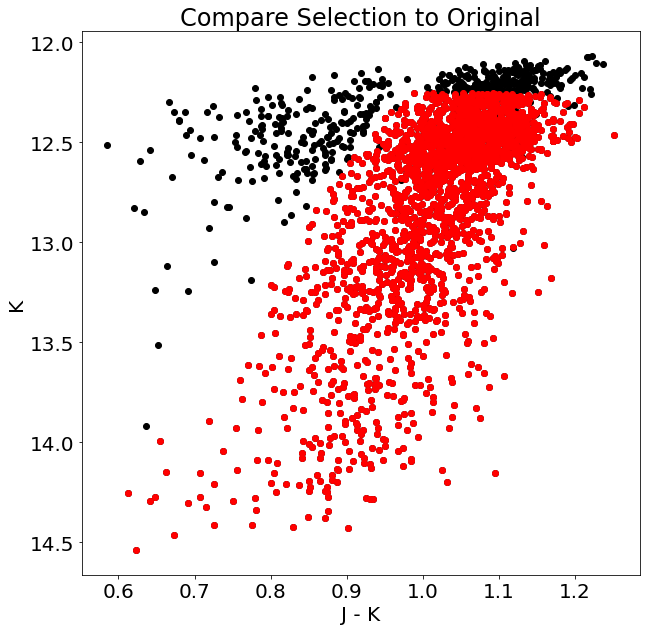

In [67]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r')

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Compare Selection to Original')

plt.show()

In [68]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(lmc_nobloop_noagb['RA'],lmc_nobloop_noagb['DEC'])
radius = lgeo.elliptical_radius(x,y)


In [69]:
#############
### MCMC  ###
#############

from scipy.optimize import minimize
import emcee
import mcmc as mc

ms = []
ms_err = []
bs = []
bs_err = []


for i in tqdm_notebook(range(len(elems)-5),desc='Progress'):
    cln = np.where((lmc_nobloop_noagb[elems[i]]>-100.)&(lmc_nobloop_noagb['SNR']>=100))
    
    rad_cln = radius[cln]
    abund_cln = lmc_nobloop_noagb[elems[i]][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, _ = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        bin_stats_err, _, _ = binned_statistic(rad_cln,abund_cln,
                                               statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                               bins=bins)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
        ms.append(np.median(flat_samples[:,0]))
        ms_err.append(mc.mad(flat_samples[:,0]))
        bs.append(np.median(flat_samples[:,1]))
        bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        ms.append(-9999.0)
        ms_err.append(-9999.0)
        bs.append(-9999.0)
        bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:51<00:00, 96.88it/s]


In [70]:
for i in range(len(ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],ms[i],ms_err[i],bs[i],
                                                                         bs_err[i]))

M_H: slope: -0.0314 +/- 0.0224 inter: -0.6266 +/- 0.0735
C_FE: slope: -0.0154 +/- 0.0131 inter: -0.3033 +/- 0.0430
N_FE: slope: -0.0070 +/- 0.0075 inter: 0.1208 +/- 0.0301
O_FE: slope: -0.0008 +/- 0.0042 inter: 0.0385 +/- 0.0148
NA_FE: slope: -0.0041 +/- 0.0176 inter: -0.1831 +/- 0.0502
MG_FE: slope: 0.0035 +/- 0.0060 inter: 0.1015 +/- 0.0211
AL_FE: slope: -0.0115 +/- 0.0115 inter: -0.3186 +/- 0.0406
SI_FE: slope: 0.0056 +/- 0.0056 inter: -0.0152 +/- 0.0186
P_FE: slope: 0.0358 +/- 0.0322 inter: -0.0190 +/- 0.1132
S_FE: slope: 0.0144 +/- 0.0234 inter: 0.1604 +/- 0.0751
K_FE: slope: 0.0310 +/- 0.0070 inter: -0.0852 +/- 0.0052
CA_FE: slope: -0.0029 +/- 0.0036 inter: 0.1132 +/- 0.0121
TI_FE: slope: -9999.0000 +/- -9999.0000 inter: -9999.0000 +/- -9999.0000
TIII_FE: slope: -9999.0000 +/- -9999.0000 inter: -9999.0000 +/- -9999.0000
V_FE: slope: -0.0055 +/- 0.0100 inter: -0.0950 +/- 0.0293
CR_FE: slope: -0.0091 +/- 0.0098 inter: 0.0788 +/- 0.0294
MN_FE: slope: -9999.0000 +/- -9999.0000 inter:

In [71]:
elems_dis = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return ms[i]*x+bs[i]
    
    cln = np.where((lmc_nobloop_noagb[elems[i]]>-100)&(lmc_nobloop_noagb['SNR']>=100))
    plug = trendline(radius[cln])
    dis = plug-lmc_nobloop_noagb[elems[i]][cln]
    
    elems_dis.append(dis)

In [72]:
re_ms = []
re_ms_err = []
re_bs = []
re_bs_err = []

prune_fact = 3.
for i in tqdm_notebook(range(len(elems)-5),desc='Progress'):
    cln = np.where((lmc_nobloop_noagb[elems[i]]>-100.)&(lmc_nobloop_noagb['SNR']>=100))
    prune = np.where((lmc_nobloop_noagb[elems[i]]>-prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc_nobloop_noagb[cln][elems[i]]))&
                     (lmc_nobloop_noagb[elems[i]]<prune_fact*mc.mad(elems_dis[i])+
                      np.median(lmc_nobloop_noagb[cln][elems[i]])))

    rad_cln = radius[prune]
    abund_cln = lmc_nobloop_noagb[elems[i]][prune]
#     endog_err = lmc_nobloop_noagb[elems_err[i]][prune]
    
#     rad_cln = radius[cln]
#     abund_cln = lmc_nobloop_noagb[elems[i]][cln]
#     abund_cln_err = lmc_nobloop_noagb[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
#         bin_stats_err, _, _ = binned_statistic(rad_cln,abund_cln,
#                                                statistic=lambda y: np.median(np.absolute(y-np.median(y))),
#                                                bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
#     print('{}: Slope {:.4f} +/- {:.4f}; Inter {:.4f} +/- {:.4f}'.format(elems[i],np.median(flat_samples[:,0]),
#                                                                         mc.mad(flat_samples[:,0]),
#                                                                         np.median(flat_samples[:,1]),
#                                                                         mc.mad(flat_samples[:,1])))
        re_ms.append(np.median(flat_samples[:,0]))
        re_ms_err.append(mc.mad(flat_samples[:,0]))
        re_bs.append(np.median(flat_samples[:,1]))
        re_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_ms.append(-9999.0)
        re_ms_err.append(-9999.0)
        re_bs.append(-9999.0)
        re_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:18<00:00, 273.48it/s]

In [73]:
for i in range(len(re_ms)):
    print('{}: slope: {:.4f} +/- {:.4f} inter: {:.4f} +/- {:.4f}'.format(elems[i],re_ms[i],re_ms_err[i],re_bs[i],
                                                                         re_bs_err[i]))

M_H: slope: -0.0227 +/- 0.0179 inter: -0.6200 +/- 0.0590
C_FE: slope: -0.0142 +/- 0.0090 inter: -0.2949 +/- 0.0354
N_FE: slope: -0.0042 +/- 0.0067 inter: 0.0972 +/- 0.0230
O_FE: slope: -0.0024 +/- 0.0026 inter: 0.0451 +/- 0.0117
NA_FE: slope: 0.0034 +/- 0.0165 inter: -0.1901 +/- 0.0538
MG_FE: slope: -0.0016 +/- 0.0053 inter: 0.1207 +/- 0.0207
AL_FE: slope: -0.0096 +/- 0.0113 inter: -0.3165 +/- 0.0386
SI_FE: slope: 0.0059 +/- 0.0046 inter: -0.0132 +/- 0.0161
P_FE: slope: 0.0252 +/- 0.0207 inter: 0.0399 +/- 0.0679
S_FE: slope: 0.0074 +/- 0.0240 inter: 0.1742 +/- 0.0764
K_FE: slope: 0.0237 +/- 0.0055 inter: -0.0814 +/- 0.0047
CA_FE: slope: -0.0026 +/- 0.0031 inter: 0.1128 +/- 0.0106
TI_FE: slope: -0.0000 +/- 0.0007 inter: -9999.9902 +/- 0.0007
TIII_FE: slope: 0.0000 +/- 0.0007 inter: -9999.9902 +/- 0.0006
V_FE: slope: -0.0058 +/- 0.0090 inter: -0.0826 +/- 0.0282
CR_FE: slope: -0.0108 +/- 0.0077 inter: 0.0892 +/- 0.0268
MN_FE: slope: -0.0001 +/- 0.0007 inter: -9999.9903 +/- 0.0006
FE_H: sl

<font size='45'>
    <b>
        Age Bins 
    </b>
</font>

In [74]:
# Ages
# ages = fits.getdata('pca_ols_ages.fits')
ages = fits.getdata('../TEST_pca_ols_ages.fits')[agb_cut][bloop_cut]

#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

lmcyoung = lmc_nobloop_noagb[young]
lmcyless = lmc_nobloop_noagb[yless]
lmcymed = lmc_nobloop_noagb[ymed]
lmcomed = lmc_nobloop_noagb[omed]
lmcold = lmc_nobloop_noagb[old]

In [75]:
young

(array([   9,   10,   49,   66,  126,  138,  375,  445,  457,  512,  531,
         576,  657,  680,  809, 1067, 1094, 1128, 1144, 1206, 1370, 1392,
        1441, 1442, 1451, 1452, 1453, 1481, 1482, 1519, 1542, 1549, 1592,
        1640, 1703, 1729, 1734, 1756, 1786, 1790, 1808, 1811, 1826, 1837,
        1864, 1872, 2051, 2073]),)

In [76]:
##################################
### Age bin initial Trendlines ###
##################################

# ### young

# young_ms = []
# young_ms_err = []
# young_bs = []
# young_bs_err = []

# ### Initial fit
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     cln = np.where((lmcyoung[elems[i]]>-100.)&(lmcyoung['SNR']>=100))
#     rad_cln = radius[young][cln]
#     abund_cln = lmcyoung[elems[i]][cln]
# #     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
#     try:
#     ### Initial Guess
#         '''
#         bin data and use slope between first two bins as the slope guess and median y value in the first bin
#         as the guess for the intercept
#         '''
#         bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
#         bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
#         bin_stats_err = []
#         for i in np.unique(bin_number)[:-1]:
#             bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
#         bin_stats_err = np.asarray(bin_stats_err)
    
#         bin_x = np.arange(len(bin_stats))+0.5
    
#         m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
#         b_guess = bin_stats[0]
#         guess = [m_guess,b_guess]
    
#         nll = lambda *args: -mc.lnL(*args)
#         result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

#         if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
#             guess = result.x
    
#     ### MCMC
#         niter = 1000
#         ndim, nwalkers = 2,500 
#         pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

#         sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
#         sampler.run_mcmc(pos, 5000, progress=True)
    
#         flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

#         young_ms.append(np.median(flat_samples[:,0]))
#         young_ms_err.append(mc.mad(flat_samples[:,0]))
#         young_bs.append(np.median(flat_samples[:,1]))
#         young_bs_err.append(mc.mad(flat_samples[:,1]))
        
#     except:
#         young_ms.append(-9999.0)
#         young_ms_err.append(-9999.0)
#         young_bs.append(-9999.0)
#         young_bs_err.append(-9999.0)
    
# ## yless

# yless_ms = []
# yless_ms_err = []
# yless_bs = []
# yless_bs_err = []

# ### Initial fit
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     cln = np.where((lmcyless[elems[i]]>-100.)&(lmcyless['SNR']>=100))
#     rad_cln = radius[yless][cln]
#     abund_cln = lmcyless[elems[i]][cln]
# #     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
#     try:
#     ### Initial Guess
#         '''
#         bin data and use slope between first two bins as the slope guess and median y value in the first bin
#         as the guess for the intercept
#         '''
#         bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
#         bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
#         bin_stats_err = []
#         for i in np.unique(bin_number)[:-1]:
#             bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
#         bin_stats_err = np.asarray(bin_stats_err)
    
#         bin_x = np.arange(len(bin_stats))+0.5
    
#         m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
#         b_guess = bin_stats[0]
#         guess = [m_guess,b_guess]
    
#         nll = lambda *args: -mc.lnL(*args)
#         result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

#         if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
#             guess = result.x
    
#     ### MCMC
#         niter = 1000
#         ndim, nwalkers = 2,500 
#         pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

#         sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
#         sampler.run_mcmc(pos, 5000, progress=True)
    
#         flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

#         yless_ms.append(np.median(flat_samples[:,0]))
#         yless_ms_err.append(mc.mad(flat_samples[:,0]))
#         yless_bs.append(np.median(flat_samples[:,1]))
#         yless_bs_err.append(mc.mad(flat_samples[:,1]))
        
#     except:
#         yless_ms.append(-9999.0)
#         yless_ms_err.append(-9999.0)
#         yless_bs.append(-9999.0)
#         yless_bs_err.append(-9999.0)
        
## ymed

ymed_ms = []
ymed_ms_err = []
ymed_bs = []
ymed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcymed[elems[i]]>-100.)&(lmcymed['SNR']>=100))
    rad_cln = radius[ymed][cln]
    abund_cln = lmcymed[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        ymed_ms.append(np.median(flat_samples[:,0]))
        ymed_ms_err.append(mc.mad(flat_samples[:,0]))
        ymed_bs.append(np.median(flat_samples[:,1]))
        ymed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        ymed_ms.append(-9999.0)
        ymed_ms_err.append(-9999.0)
        ymed_bs.append(-9999.0)
        ymed_bs_err.append(-9999.0)
        
### omed

omed_ms = []
omed_ms_err = []
omed_bs = []
omed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcomed[elems[i]]>-100.)&(lmcomed['SNR']>=100))
    rad_cln = radius[omed][cln]
    abund_cln = lmcomed[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        omed_ms.append(np.median(flat_samples[:,0]))
        omed_ms_err.append(mc.mad(flat_samples[:,0]))
        omed_bs.append(np.median(flat_samples[:,1]))
        omed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        omed_ms.append(-9999.0)
        omed_ms_err.append(-9999.0)
        omed_bs.append(-9999.0)
        omed_bs_err.append(-9999.0)

### old

old_ms = []
old_ms_err = []
old_bs = []
old_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcold[elems[i]]>-100.)&(lmcold['SNR']>=100))
    rad_cln = radius[old][cln]
    abund_cln = lmcold[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        old_ms.append(np.median(flat_samples[:,0]))
        old_ms_err.append(mc.mad(flat_samples[:,0]))
        old_bs.append(np.median(flat_samples[:,1]))
        old_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        old_ms.append(-9999.0)
        old_ms_err.append(-9999.0)
        old_bs.append(-9999.0)
        old_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:55<00:00, 89.56it/s]

100%|██████████| 5000/5000 [01:00<00:00, 83.21it/s]

100%|██████████| 5000/5000 [01:00<00:00, 83.13it/s]

In [77]:
# young_ms

In [78]:
############################################
### Find distances between data and fits ###
############################################

# young_dist = []
# for i in range(len(elems)-5):
    
#     def trendline(x):
#         return young_ms[i]*x+young_bs[i]
    
#     cln = np.where((lmcyoung[elems[i]]>-100))
#     plug = trendline(radius[young][cln])
#     dist = plug-lmcyoung[elems[i]][cln]
    
#     young_dist.append(dist) 
    
# yless_dist = []
# for i in range(len(elems)-5):
    
#     def trendline(x):
#         return yless_ms[i]*x+yless_bs[i]
    
#     cln = np.where((lmcyless[elems[i]]>-100))
#     plug = trendline(radius[yless][cln])
#     dist = plug-lmcyless[elems[i]][cln]
    
#     yless_dist.append(dist) 
    
ymed_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return ymed_ms[i]*x+ymed_bs[i]
    
    cln = np.where((lmcymed[elems[i]]>-100))
    plug = trendline(radius[ymed][cln])
    dist = plug-lmcymed[elems[i]][cln]
    
    ymed_dist.append(dist) 
    
omed_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return omed_ms[i]*x+omed_bs[i]
    
    cln = np.where((lmcomed[elems[i]]>-100))
    plug = trendline(radius[omed][cln])
    dist = plug-lmcomed[elems[i]][cln]
    
    omed_dist.append(dist) 
    
old_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return old_ms[i]*x+old_bs[i]
    
    cln = np.where((lmcold[elems[i]]>-100))
    plug = trendline(radius[old][cln])
    dist = plug-lmcold[elems[i]][cln]
    
    old_dist.append(dist)

In [79]:
#################################
### Second Age bin Trendlines ###
#################################

prune_fact = 3.

# ### young

# re_young_ms = []
# re_young_ms_err = []
# re_young_bs = []
# re_young_bs_err = []

# ### Initial fit
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     cln = np.where((lmcyoung[elems[i]]>-100))
#     prune = np.where((lmcyoung[elems[i]]>-prune_fact*mc.mad(young_dist[i])+
#                       np.median(lmcyoung[cln][elems[i]]))&
#                      (lmcyoung[elems[i]]<prune_fact*mc.mad(young_dist[i])+
#                       np.median(lmcyoung[cln][elems[i]])))
    
#     rad_cln = radius[young][prune]
#     abund_cln = lmcyoung[elems[i]][prune]
    
#     try:
#     ### Initial Guess
#         '''
#         bin data and use slope between first two bins as the slope guess and median y value in the first bin
#         as the guess for the intercept
#         '''
#         bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
#         bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
#         bin_stats_err = []
#         for i in np.unique(bin_number)[:-1]:
#             bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
#         bin_stats_err = np.asarray(bin_stats_err)
    
#         bin_x = np.arange(len(bin_stats))+0.5
    
#         m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
#         b_guess = bin_stats[0]
#         guess = [m_guess,b_guess]
    
#         nll = lambda *args: -mc.lnL(*args)
#         result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

#         if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
#             guess = result.x
    
#     ### MCMC
#         niter = 1000
#         ndim, nwalkers = 2,500 
#         pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

#         sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
#         sampler.run_mcmc(pos, 5000, progress=True)
    
#         flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

#         re_young_ms.append(np.median(flat_samples[:,0]))
#         re_young_ms_err.append(mc.mad(flat_samples[:,0]))
#         re_young_bs.append(np.median(flat_samples[:,1]))
#         re_young_bs_err.append(mc.mad(flat_samples[:,1]))
        
#     except:
#         re_young_ms.append(-9999.0)
#         re_young_ms_err.append(-9999.0)
#         re_young_bs.append(-9999.0)
#         re_young_bs_err.append(-9999.0)
    
# ## yless

# re_yless_ms = []
# re_yless_ms_err = []
# re_yless_bs = []
# re_yless_bs_err = []

# ### Initial fit
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     cln = np.where((lmcyless[elems[i]]>-100))
#     prune = np.where((lmcyless[elems[i]]>-prune_fact*mc.mad(yless_dist[i])+
#                       np.median(lmcyless[cln][elems[i]]))&
#                      (lmcyless[elems[i]]<prune_fact*mc.mad(yless_dist[i])+
#                       np.median(lmcyless[cln][elems[i]])))
    
#     rad_cln = radius[yless][prune]
#     abund_cln = lmcyless[elems[i]][prune]
    
#     try:
#     ### Initial Guess
#         '''
#         bin data and use slope between first two bins as the slope guess and median y value in the first bin
#         as the guess for the intercept
#         '''
#         bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
#         bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
#         bin_stats_err = []
#         for i in np.unique(bin_number)[:-1]:
#             bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
#         bin_stats_err = np.asarray(bin_stats_err)
    
#         bin_x = np.arange(len(bin_stats))+0.5
    
#         m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
#         b_guess = bin_stats[0]
#         guess = [m_guess,b_guess]
    
#         nll = lambda *args: -mc.lnL(*args)
#         result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

#         if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
#             guess = result.x
    
#     ### MCMC
#         niter = 1000
#         ndim, nwalkers = 2,500 
#         pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

#         sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
#         sampler.run_mcmc(pos, 5000, progress=True)
    
#         flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

#         re_yless_ms.append(np.median(flat_samples[:,0]))
#         re_yless_ms_err.append(mc.mad(flat_samples[:,0]))
#         re_yless_bs.append(np.median(flat_samples[:,1]))
#         re_yless_bs_err.append(mc.mad(flat_samples[:,1]))
        
#     except:
#         re_yless_ms.append(-9999.0)
#         re_yless_ms_err.append(-9999.0)
#         re_yless_bs.append(-9999.0)
#         re_yless_bs_err.append(-9999.0)
        
### ymed

re_ymed_ms = []
re_ymed_ms_err = []
re_ymed_bs = []
re_ymed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcymed[elems[i]]>-100))
    prune = np.where((lmcymed[elems[i]]>-prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]]))&
                     (lmcymed[elems[i]]<prune_fact*mc.mad(ymed_dist[i])+
                      np.median(lmcymed[cln][elems[i]])))
    
    rad_cln = radius[ymed][prune]
    abund_cln = lmcymed[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)

        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_ymed_ms.append(np.median(flat_samples[:,0]))
        re_ymed_ms_err.append(mc.mad(flat_samples[:,0]))
        re_ymed_bs.append(np.median(flat_samples[:,1]))
        re_ymed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_ymed_ms.append(-9999.0)
        re_ymed_ms_err.append(-9999.0)
        re_ymed_bs.append(-9999.0)
        re_ymed_bs_err.append(-9999.0)
        
### omed

re_omed_ms = []
re_omed_ms_err = []
re_omed_bs = []
re_omed_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcomed[elems[i]]>-100))
    prune = np.where((lmcomed[elems[i]]>-prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]]))&
                     (lmcomed[elems[i]]<prune_fact*mc.mad(omed_dist[i])+
                      np.median(lmcomed[cln][elems[i]])))
    
    rad_cln = radius[omed][prune]
    abund_cln = lmcomed[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    
        re_omed_ms.append(np.median(flat_samples[:,0]))
        re_omed_ms_err.append(mc.mad(flat_samples[:,0]))
        re_omed_bs.append(np.median(flat_samples[:,1]))
        re_omed_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_omed_ms.append(-9999.0)
        re_omed_ms_err.append(-9999.0)
        re_omed_bs.append(-9999.0)
        re_omed_bs_err.append(-9999.0)

### old

re_old_ms = []
re_old_ms_err = []
re_old_bs = []
re_old_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcold[elems[i]]>-100))
    prune = np.where((lmcold[elems[i]]>-prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]]))&
                     (lmcold[elems[i]]<prune_fact*mc.mad(old_dist[i])+
                      np.median(lmcold[cln][elems[i]])))
    
    
    rad_cln = radius[old][prune]
    abund_cln = lmcold[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_old_ms.append(np.median(flat_samples[:,0]))
        re_old_ms_err.append(mc.mad(flat_samples[:,0]))
        re_old_bs.append(np.median(flat_samples[:,1]))
        re_old_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_old_ms.append(-9999.0)
        re_old_ms_err.append(-9999.0)
        re_old_bs.append(-9999.0)
        re_old_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:57<00:00, 87.68it/s]


100%|██████████| 5000/5000 [00:59<00:00, 83.45it/s]


100%|██████████| 5000/5000 [00:18<00:00, 265.67it/s]


In [80]:
# ####################
# ### Summary plot ###
# ####################

# # elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

# idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
#        np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
#        np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
#        np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
#        np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
#        #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

# good_young = []
# good_yless = []
# good_ymed = []
# good_omed = []
# good_old = []
# good_over = []

# err_young = []
# err_yless = []
# err_ymed = []
# err_omed = []
# err_old = []
# err_over = []

# for i in idx:
#     good_young.append(re_young_ms[i])
#     good_yless.append(re_yless_ms[i])
#     good_ymed.append(re_ymed_ms[i])
#     good_omed.append(re_omed_ms[i])
#     good_old.append(re_old_ms[i])
#     good_over.append(re_ms[i])
    
#     err_young.append(re_young_ms_err[i])
#     err_yless.append(re_yless_ms_err[i])
#     err_ymed.append(re_ymed_ms_err[i])
#     err_omed.append(re_omed_ms_err[i])
#     err_old.append(re_old_ms_err[i])
#     err_over.append(re_ms_err[i])

# matplotlib.rcParams.update({'font.size': 20})
# fig = plt.figure(figsize=[20,10])

# plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
# plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

# plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
# plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

# plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
# plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

# plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
# plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

# plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
# plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

# xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
#             '[Ni/Fe]']#,'[V/Fe]']

# xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
# plt.xticks(xplotpos,xplotlab)

# plt.axvline(0.5,c='k',ls='--')
# plt.axvline(4.5,c='k',ls='--')
# plt.axvline(6.5,c='k',ls='--')
# plt.axhline(0.0,c='slategrey',ls='-')
# plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# # plt.gca().set_ylim(top=0.05)

# plt.text(-0.375,0.0435,'Iron',fontsize=30)
# plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
# plt.text(5.0,0.0435,'Odd Z',fontsize=30)
# plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# # plt.ylim(bottom=-0.045)
# plt.ylim(-0.05,0.05)

# plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
# plt.tight_layout()
# plt.savefig('AGBCutgradientSummaryplot.pdf',bbox_inches='tight')
# plt.show()

In [81]:
####################################
### Make Second Version Age Bins ###
####################################

### combine youngest two bins

young2 = np.where(ages['AGE']<=np.log10(2.0*10**9))
lmcyoung2 = lmc_nobloop_noagb[young2]


In [82]:
##################################
### Age bin initial Trendlines ###
##################################

### young2

young2_ms = []
young2_ms_err = []
young2_bs = []
young2_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyoung2[elems[i]]>-100.)&(lmcyoung2['SNR']>=100))
    rad_cln = radius[young2][cln]
    abund_cln = lmcyoung2[elems[i]][cln]
#     abund_cln_err = lmc[elems[i]+'_ERR'][cln]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        young2_ms.append(np.median(flat_samples[:,0]))
        young2_ms_err.append(mc.mad(flat_samples[:,0]))
        young2_bs.append(np.median(flat_samples[:,1]))
        young2_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        young2_ms.append(-9999.0)
        young2_ms_err.append(-9999.0)
        young2_bs.append(-9999.0)
        young2_bs_err.append(-9999.0)

100%|██████████| 5000/5000 [00:57<00:00, 86.65it/s]

In [83]:
############################################
### Find distances between data and fits ###
############################################

young2_dist = []
for i in range(len(elems)-5):
    
    def trendline(x):
        return young2_ms[i]*x+young2_bs[i]
    
    cln = np.where((lmcyoung2[elems[i]]>-100))
    plug = trendline(radius[young2][cln])
    dist = plug-lmcyoung2[elems[i]][cln]
    
    young2_dist.append(dist) 

In [84]:
#################################
### Second Age bin Trendlines ###
#################################

prune_fact = 3.

### young2

re_young2_ms = []
re_young2_ms_err = []
re_young2_bs = []
re_young2_bs_err = []

### Initial fit
for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
    cln = np.where((lmcyoung2[elems[i]]>-100))
    prune = np.where((lmcyoung2[elems[i]]>-prune_fact*mc.mad(young2_dist[i])+
                      np.median(lmcyoung2[cln][elems[i]]))&
                     (lmcyoung2[elems[i]]<prune_fact*mc.mad(young2_dist[i])+
                      np.median(lmcyoung2[cln][elems[i]])))
    
    rad_cln = radius[young2][prune]
    abund_cln = lmcyoung2[elems[i]][prune]
    
    try:
    ### Initial Guess
        '''
        bin data and use slope between first two bins as the slope guess and median y value in the first bin
        as the guess for the intercept
        '''
        bins = np.arange(np.floor(np.min(rad_cln)),np.ceil(np.max(rad_cln)),1.0)
        bin_stats, _, bin_number = binned_statistic(rad_cln,abund_cln,statistic='median',bins=bins)
        
        bin_stats_err = []
        for i in np.unique(bin_number)[:-1]:
            bin_stats_err.append(mc.mad(abund_cln[np.where(bin_number==i)]))
        bin_stats_err = np.asarray(bin_stats_err)
    
        bin_x = np.arange(len(bin_stats))+0.5
    
        m_guess = (bin_stats[1]-bin_stats[0])/(bin_x[1]-bin_x[0])
        b_guess = bin_stats[0]
        guess = [m_guess,b_guess]
    
        nll = lambda *args: -mc.lnL(*args)
        result = minimize(nll, guess, args=(bin_x, bin_stats, bin_stats_err))

        if not np.isfinite(mc.lnProb(guess,bin_x,bin_stats,bin_stats_err)):
            guess = result.x
    
    ### MCMC
        niter = 1000
        ndim, nwalkers = 2,500 
        pos = [guess + (10**-3)*np.random.randn(ndim) for i in range(nwalkers)]

        sampler = emcee.EnsembleSampler(nwalkers, ndim, mc.lnProb, args=(bin_x, bin_stats, bin_stats_err))
        sampler.run_mcmc(pos, 5000, progress=True)
    
        flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

        re_young2_ms.append(np.median(flat_samples[:,0]))
        re_young2_ms_err.append(mc.mad(flat_samples[:,0]))
        re_young2_bs.append(np.median(flat_samples[:,1]))
        re_young2_bs_err.append(mc.mad(flat_samples[:,1]))
        
    except:
        re_young2_ms.append(-9999.0)
        re_young2_ms_err.append(-9999.0)
        re_young2_bs.append(-9999.0)
        re_young2_bs_err.append(-9999.0)        

100%|██████████| 5000/5000 [00:17<00:00, 286.09it/s]

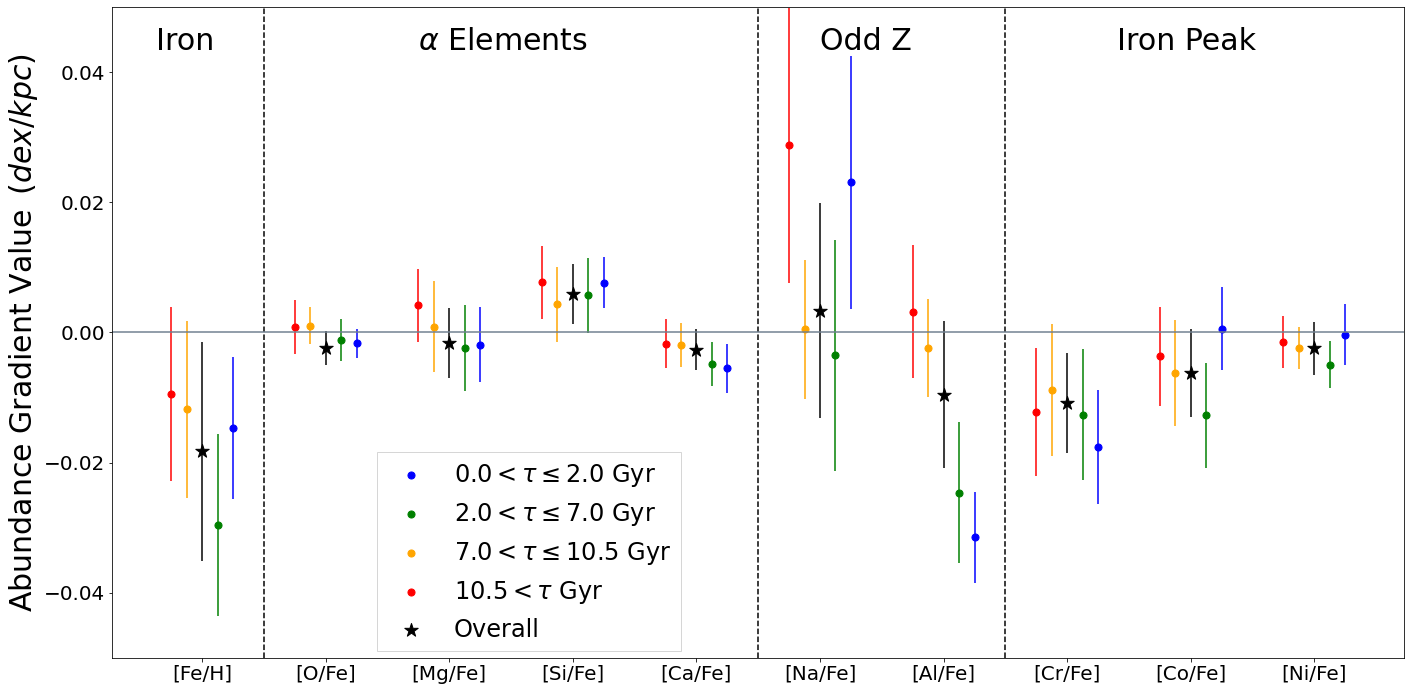

In [85]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young2 = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young2 = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young2.append(re_young2_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_ms[i])
    
    err_young2.append(re_young2_ms_err[i])
    err_ymed.append(re_ymed_ms_err[i])
    err_omed.append(re_omed_ms_err[i])
    err_old.append(re_old_ms_err[i])
    err_over.append(re_ms_err[i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young2,c='blue',label='$0.0 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young2,yerr=err_young2,c='blue',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
plt.savefig('../figures/AGBCutCombogradientSummaryplot.pdf',bbox_inches='tight')
plt.show()

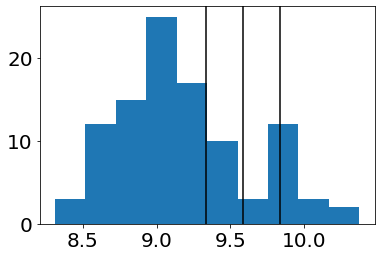

1.2083550851660225
1s 2.1540467537758112
2s 3.8398625324728837
3s 6.8450437496045415


In [63]:
plt.hist(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])
plt.axvline(util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])+
            np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]),c='k')
plt.axvline(2*util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])+
            np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]),c='k')
plt.axvline(3*util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])+
            np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]),c='k')
plt.show()

print(10**np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])/10**9)

# print(util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]))

print('1s',10**(util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])+
                np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]))/10**9)

print('2s',10**(2.*util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])+
                np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]))/10**9)

print('3s',10**(3.*util.mad(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)])+
                np.median(ages['AGE'][np.where(lmc_nobloop_noagb['FE_H']>-0.5)]))/10**9)

In [29]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Gradients/MCMC_LMC_Gradients'

In [ ]:
### OVERALL
overallgradcat = Table()
overallgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
overallgradcol_stats = Column(np.asarray(re_med_ms),name='GRAD')
overallgradcol_edges = Column(np.asarray(med_m_devs),name='GRAD_ERR')
overallgradcol_number = Column(np.asarray(re_med_bs),name='INTER')
overallgradcol_spread = Column(np.asarray(med_b_devs),name='INTER_ERR')

overallgradcat.add_column(overallgradcol_elems)
overallgradcat.add_column(overallgradcol_stats)
overallgradcat.add_column(overallgradcol_edges)
overallgradcat.add_column(overallgradcol_number)
overallgradcat.add_column(overallgradcol_spread)

# overallgradcat.write('overallgrads.fits',format='fits')#,overwrite=True)

### young
younggradcat = Table()
younggradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
younggradcol_stats = Column(np.asarray(re_young_ms),name='GRAD')
younggradcol_edges = Column(np.asarray(young_m_devs),name='GRAD_ERR')
younggradcol_number = Column(np.asarray(re_young_bs),name='INTER')
younggradcol_spread = Column(np.asarray(young_b_devs),name='INTER_ERR')

younggradcat.add_column(younggradcol_elems)
younggradcat.add_column(younggradcol_stats)
younggradcat.add_column(younggradcol_edges)
younggradcat.add_column(younggradcol_number)
younggradcat.add_column(younggradcol_spread)

# younggradcat.write('younggrads.fits',format='fits'#,overwrite=True)

### yless
ylessgradcat = Table()
ylessgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ylessgradcol_stats = Column(np.asarray(re_yless_ms),name='GRAD')
ylessgradcol_edges = Column(np.asarray(yless_m_devs),name='GRAD_ERR')
ylessgradcol_number = Column(np.asarray(re_yless_bs),name='INTER')
ylessgradcol_spread = Column(np.asarray(yless_b_devs),name='INTER_ERR')

ylessgradcat.add_column(ylessgradcol_elems)
ylessgradcat.add_column(ylessgradcol_stats)
ylessgradcat.add_column(ylessgradcol_edges)
ylessgradcat.add_column(ylessgradcol_number)
ylessgradcat.add_column(ylessgradcol_spread)

# ylessgradcat.write('ylessgrads.fits',format='fits'#,overwrite=True)

### ymed
ymedgradcat = Table()
ymedgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ymedgradcol_stats = Column(np.asarray(re_ymed_ms),name='GRAD')
ymedgradcol_edges = Column(np.asarray(ymed_m_devs),name='GRAD_ERR')
ymedgradcol_number = Column(np.asarray(re_ymed_bs),name='INTER')
ymedgradcol_spread = Column(np.asarray(ymed_b_devs),name='INTER_ERR')

ymedgradcat.add_column(ymedgradcol_elems)
ymedgradcat.add_column(ymedgradcol_stats)
ymedgradcat.add_column(ymedgradcol_edges)
ymedgradcat.add_column(ymedgradcol_number)
ymedgradcat.add_column(ymedgradcol_spread)

# ymedgradcat.write('ymedgrads.fits',format='fits'#,overwrite=True)

### omed
omedgradcat = Table()
omedgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
omedgradcol_stats = Column(np.asarray(re_omed_ms),name='GRAD')
omedgradcol_edges = Column(np.asarray(omed_m_devs),name='GRAD_ERR')
omedgradcol_number = Column(np.asarray(re_omed_bs),name='INTER')
omedgradcol_spread = Column(np.asarray(omed_b_devs),name='INTER_ERR')

omedgradcat.add_column(omedgradcol_elems)
omedgradcat.add_column(omedgradcol_stats)
omedgradcat.add_column(omedgradcol_edges)
omedgradcat.add_column(omedgradcol_number)
omedgradcat.add_column(omedgradcol_spread)

# omedgradcat.write('omedgrads.fits',format='fits'#,overwrite=True)

### old
oldgradcat = Table()
oldgradcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
oldgradcol_stats = Column(np.asarray(re_old_ms),name='GRAD')
oldgradcol_edges = Column(np.asarray(old_m_devs),name='GRAD_ERR')
oldgradcol_number = Column(np.asarray(re_old_bs),name='INTER')
oldgradcol_spread = Column(np.asarray(old_b_devs),name='INTER_ERR')

oldgradcat.add_column(oldgradcol_elems)
oldgradcat.add_column(oldgradcol_stats)
oldgradcat.add_column(oldgradcol_edges)
oldgradcat.add_column(oldgradcol_number)
oldgradcat.add_column(oldgradcol_spread)

# oldgradcat.write('oldgrads.fits',format='fits'#,overwrite=True)

In [ ]:
test = fits.getdata('younggrads.fits')
test['GRAD'] == np.asarray(re_young_ms)

In [ ]:
prune_fact = 3.0

radiusyoung = radius[young]
radiusyless = radius[yless]
radiusymed = radius[ymed]
radiusomed = radius[omed]
radiusold = radius[old]

### young
young_stats = [] 
young_edges = []
young_number = []
young_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13young[elems[i]]>-100.)
    young_cln = np.where((r13young[elems[i]]>-prune_fact*util.mad(young_dist[i])+
                          np.median(r13young[cln][elems[i]]))&
                         (r13young[elems[i]]<prune_fact*util.mad(young_dist[i])+
                          np.median(r13young[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusyoung[young_cln])),np.ceil(np.max(radiusyoung[young_cln])),1)
        young_bin_stats, young_bin_edges, young_binnumber = binned_statistic(radiusyoung[young_cln],
                                                                             r13young[elems[i]][young_cln],
                                                                             statistic='median',bins=bins)
        young_mad, _, _ = binned_statistic(radiusyoung[young_cln],r13young[elems[i]][young_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_edges.append(young_bin_edges)
        young_number.append(young_binnumber)
        young_spread.append(young_mad)
        
    
    except:
            young_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            young_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            young_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            young_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

        
### yless
yless_stats = [] 
yless_edges = []
yless_number = []
yless_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13yless[elems[i]]>-100.)
    yless_cln = np.where((r13yless[elems[i]]>-prune_fact*util.mad(yless_dist[i])+
                          np.median(r13yless[cln][elems[i]]))&
                         (r13yless[elems[i]]<prune_fact*util.mad(yless_dist[i])+
                          np.median(r13yless[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusyless[yless_cln])),np.ceil(np.max(radiusyless[yless_cln])),1)
        yless_bin_stats, yless_bin_edges, yless_binnumber = binned_statistic(radiusyless[yless_cln],
                                                                             r13yless[elems[i]][yless_cln],
                                                                             statistic='median',bins=bins)
        yless_mad, _, _ = binned_statistic(radiusyless[yless_cln],r13yless[elems[i]][yless_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_edges.append(yless_bin_edges)
        yless_number.append(yless_binnumber)
        yless_spread.append(yless_mad)
        
    
    except:
            yless_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            yless_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            yless_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            yless_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### ymed
ymed_stats = [] 
ymed_edges = []
ymed_number = []
ymed_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13ymed[elems[i]]>-100.)
    ymed_cln = np.where((r13ymed[elems[i]]>-prune_fact*util.mad(ymed_dist[i])+
                          np.median(r13ymed[cln][elems[i]]))&
                         (r13ymed[elems[i]]<prune_fact*util.mad(ymed_dist[i])+
                          np.median(r13ymed[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusymed[ymed_cln])),np.ceil(np.max(radiusymed[ymed_cln])),1)
        ymed_bin_stats, ymed_bin_edges, ymed_binnumber = binned_statistic(radiusymed[ymed_cln],
                                                                             r13ymed[elems[i]][ymed_cln],
                                                                             statistic='median',bins=bins)
        ymed_mad, _, _ = binned_statistic(radiusymed[ymed_cln],r13ymed[elems[i]][ymed_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_edges.append(ymed_bin_edges)
        ymed_number.append(ymed_binnumber)
        ymed_spread.append(ymed_mad)
        
    
    except:
            ymed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            ymed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            ymed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            ymed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### omed
omed_stats = [] 
omed_edges = []
omed_number = []
omed_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13omed[elems[i]]>-100.)
    omed_cln = np.where((r13omed[elems[i]]>-prune_fact*util.mad(omed_dist[i])+
                          np.median(r13omed[cln][elems[i]]))&
                         (r13omed[elems[i]]<prune_fact*util.mad(omed_dist[i])+
                          np.median(r13omed[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusomed[omed_cln])),np.ceil(np.max(radiusomed[omed_cln])),1)
        omed_bin_stats, omed_bin_edges, omed_binnumber = binned_statistic(radiusomed[omed_cln],
                                                                             r13omed[elems[i]][omed_cln],
                                                                             statistic='median',bins=bins)
        omed_mad, _, _ = binned_statistic(radiusomed[omed_cln],r13omed[elems[i]][omed_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_edges.append(omed_bin_edges)
        omed_number.append(omed_binnumber)
        omed_spread.append(omed_mad)
        
    
    except:
            omed_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            omed_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            omed_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            omed_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
        
### old
old_stats = [] 
old_edges = []
old_number = []
old_spread = []

for i in range(len(elems)-5):
    cln = np.where(r13old[elems[i]]>-100.)
    old_cln = np.where((r13old[elems[i]]>-prune_fact*util.mad(old_dist[i])+
                          np.median(r13old[cln][elems[i]]))&
                         (r13old[elems[i]]<prune_fact*util.mad(old_dist[i])+
                          np.median(r13old[cln][elems[i]])))
    try:
        bins = np.arange(np.floor(np.min(radiusold[old_cln])),np.ceil(np.max(radiusold[old_cln])),1)
        old_bin_stats, old_bin_edges, old_binnumber = binned_statistic(radiusold[old_cln],
                                                                             r13old[elems[i]][old_cln],
                                                                             statistic='median',bins=bins)
        old_mad, _, _ = binned_statistic(radiusold[old_cln],r13old[elems[i]][old_cln],
                                                 statistic=lambda y: util.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_edges.append(old_bin_edges)
        old_number.append(old_binnumber)
        old_spread.append(old_mad)
        
    
    except:
            old_stats.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            old_edges.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            old_number.append(np.multiply(-9999.0,np.ones(len(bins)-1)))
            old_spread.append(np.multiply(-9999.0,np.ones(len(bins)-1)))

In [ ]:
ylesstrendcat

In [ ]:
### YOUNG
cp_young_stats = np.copy(young_stats).tolist()
cp_young_spread = np.copy(young_spread).tolist()

for i in range(len(cp_young_stats)):
    if len(cp_young_stats[i])<6:
        cp_young_stats[i] = np.append(cp_young_stats[i],-9999.0*np.ones(6-len(cp_young_stats[i])))
        cp_young_spread[i] = np.append(cp_young_spread[i],-9999.0*np.ones(6-len(cp_young_spread[i])))
        
youngtrendcat = Table()
youngtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
youngtrendcol_stats = Column(np.squeeze(np.asarray(cp_young_stats)),name='STATS')
youngtrendcol_spread = Column(np.asarray(cp_young_spread),name='SPREAD')

youngtrendcat.add_column(youngtrendcol_elems)
youngtrendcat.add_column(youngtrendcol_stats)
youngtrendcat.add_column(youngtrendcol_spread)

# youngtrendcat.write('youngtrends.fits')#,overwrite=True)

### yless
cp_yless_stats = np.copy(yless_stats).tolist()
cp_yless_spread = np.copy(yless_spread).tolist()

for i in range(len(cp_yless_stats)):
    if len(cp_yless_stats[i])<7:
        cp_yless_stats[i] = np.append(cp_yless_stats[i],-9999.0*np.ones(7-len(cp_yless_stats[i])))
        cp_yless_spread[i] = np.append(cp_yless_spread[i],-9999.0*np.ones(7-len(cp_yless_spread[i])))
        
ylesstrendcat = Table()
ylesstrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ylesstrendcol_stats = Column(np.squeeze(np.asarray(cp_yless_stats)),name='STATS')
ylesstrendcol_spread = Column(np.asarray(cp_yless_spread),name='SPREAD')

ylesstrendcat.add_column(ylesstrendcol_elems)
ylesstrendcat.add_column(ylesstrendcol_stats)
ylesstrendcat.add_column(ylesstrendcol_spread)

# ylesstrendcat.write('ylesstrends.fits')#,overwrite=True)

### YMED
cp_ymed_stats = np.copy(ymed_stats).tolist()
cp_ymed_spread  = np.copy(ymed_spread).tolist()

for i in range(len(cp_ymed_stats)):
    if len(cp_ymed_stats[i])<6:
        cp_ymed_stats[i] = np.append(cp_ymed_stats[i],-9999.0*np.ones(6-len(cp_ymed_stats[i])))
        cp_ymed_spread[i] = np.append(cp_ymed_spread[i],-9999.0*np.ones(6-len(cp_ymed_spread[i])))
        
ymedtrendcat = Table()
ymedtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
ymedtrendcol_stats = Column(np.squeeze(np.asarray(cp_ymed_stats)),name='STATS')
ymedtrendcol_spread = Column(np.asarray(cp_ymed_spread),name='SPREAD')

ymedtrendcat.add_column(ymedtrendcol_elems)
ymedtrendcat.add_column(ymedtrendcol_stats)
ymedtrendcat.add_column(ymedtrendcol_spread)

# ymedtrendcat.write('ymedtrends.fits')#,overwrite=True)

### OMED
cp_omed_stats = np.copy(omed_stats).tolist()
cp_omed_spread  = np.copy(omed_spread).tolist()

for i in range(len(cp_omed_stats)):
    if len(cp_omed_stats[i])<6:
        cp_omed_stats[i] = np.append(cp_omed_stats[i],-9999.0*np.ones(6-len(cp_omed_stats[i])))
        cp_omed_spread[i] = np.append(cp_omed_spread[i],-9999.0*np.ones(6-len(cp_omed_spread[i])))
        
omedtrendcat = Table()
omedtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
omedtrendcol_stats = Column(np.squeeze(np.asarray(cp_omed_stats)),name='STATS')
omedtrendcol_spread = Column(np.asarray(cp_omed_spread),name='SPREAD')

omedtrendcat.add_column(omedtrendcol_elems)
omedtrendcat.add_column(omedtrendcol_stats)
omedtrendcat.add_column(omedtrendcol_spread)

# omedtrendcat.write('omedtrends.fits')#,overwrite=True)

### OLD
cp_old_stats = np.copy(old_stats).tolist()
cp_old_spread  = np.copy(old_spread).tolist()

for i in range(len(cp_old_stats)):
    if len(cp_old_stats[i])<6:
        cp_old_stats[i] = np.append(cp_old_stats[i],-9999.0*np.ones(6-len(cp_old_stats[i])))
        cp_old_spread[i] = np.append(cp_old_spread[i],-9999.0*np.ones(6-len(cp_old_spread[i])))
        
oldtrendcat = Table()
oldtrendcol_elems = Column(np.array(['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe',
                                  'K_Fe','Ca_Fe_','Ti_Fe','TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe',
                                  'Ni_Fe','Cu_Fe']),name='X_FE')
oldtrendcol_stats = Column(np.squeeze(np.asarray(cp_old_stats)),name='STATS')
oldtrendcol_spread = Column(np.asarray(cp_old_spread),name='SPREAD')

oldtrendcat.add_column(oldtrendcol_elems)
oldtrendcat.add_column(oldtrendcol_stats)
oldtrendcat.add_column(oldtrendcol_spread)

# oldtrendcat.write('oldtrends.fits')#,overwrite=True)

In [ ]:
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 30})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    
    young_ = np.where((r13young[elems[i]]>-100))#&(r13young['SNR']>=100))
    yless_ = np.where((r13yless[elems[i]]>-100))#&(r13yless['SNR']>=100))
    ymed_ = np.where((r13ymed[elems[i]]>-100))#&(r13ymed['SNR']>=100))
    omed_ = np.where((r13omed[elems[i]]>-100))#&(r13omed['SNR']>=100))
    old_ = np.where((r13old[elems[i]]>-100))#&(r13old['SNR']>=100))
    
    fig = plt.figure(figsize=[14,12])

#     plt.scatter(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple',marker='o',s=100)
    plt.errorbar(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],yerr=young_spread[i],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.scatter(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue',marker='o',s=100)
    plt.errorbar(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],yerr=yless_spread[i],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.scatter(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green',marker='o',s=100)
    plt.errorbar(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],yerr=ymed_spread[i],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.scatter(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange',marker='o',s=100)
    plt.errorbar(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],yerr=omed_spread[i],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

#     plt.scatter(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red',marker='o',s=100)
    plt.errorbar(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],yerr=old_spread[i],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[i],
                                                                                      young_m_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[i],
                                                                                      yless_m_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[i],
                                                                                      ymed_m_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[i],
                                                                                       omed_m_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_old_ms[i],
                                                                               old_m_devs[i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[i],
                                                                          med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize=15,frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=30)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')
#     plt.ylim(top = ytops[i])
    
#     if elems[i] == 'CR_FE':
#         plt.ylim(bottom = -0.4)
#         plt.ylim(top = 0.3)
        
#     if elems[i] == 'MG_FE':
#         plt.ylim(0.0, 0.225)
        
#     if elems[i] == 'SI_FE':
#         plt.ylim(top = 0.2)
        
    if elems[i] == 'NA_FE':
        plt.ylim(-0.35,0.)
        
#     if elems[i] == 'O_FE':
#         plt.ylim(top = 0.150)
        
#     if elems[i] == 'CA_FE':
#         plt.ylim(top = 0.225)
        
#     if elems[i] == 'AL_FE':
#         plt.ylim(top = -0.05)
        
#     if elems[i] == 'CO_FE':
#         plt.ylim(top = 0.25)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('medians_age_bins_{}2.png'.format(els[i]),bbox_inches='tight')
    plt.tight_layout()
#     plt.savefig('test_thisone_medians_age_bins_{}2.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

In [ ]:
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/FE]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge_Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']
els = ['M_H','C_Fe','N_Fe','O_Fe','Na_Fe','Mg_Fe','Al_Fe','Si_Fe','P_Fe','S_Fe','K_Fe','Ca_Fe_','Ti_Fe',
       'TiII_FE','V_Fe','Cr_Fe','Mn_Fe','Fe_H','Co_Fe','Ni_Fe','Cu_Fe','Ge_Fe','Rb_Fe','Ce_Fe','Nd_Fe','Yb_Fe']

ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

ironsubs = [221,222,223,224]

matplotlib.rcParams.update({'font.size': 18})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook([3,5,7,11],desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[i]*x+re_young_bs[i]
    def ylesstrendline(x):
        return re_yless_ms[i]*x+re_yless_bs[i]
    def ymedtrendline(x):
        return re_ymed_ms[i]*x+re_ymed_bs[i]
    def omedtrendline(x):
        return re_omed_ms[i]*x+re_omed_bs[i]
    def oldtrendline(x):
        return re_old_ms[i]*x+re_old_bs[i]
    
#     if i == 3:
#         j = 0
#     if i == 5:
#         j = 1
#     if i == 7:
#         j = 2
#     if i == 11:
#         j = 3
    
#     plt.subplots(ironsubs[j])

    fig = plt.figure(figsize=[14,12])
    
    plt.errorbar(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],yerr=young_spread[i],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[i]))+0.5+0.25,young_stats[i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young

    
    plt.errorbar(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],yerr=yless_spread[i],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[i]))+0.5+0.125,yless_stats[i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    

    plt.errorbar(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],yerr=ymed_spread[i],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[i]))+0.5,ymed_stats[i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed


    plt.errorbar(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],yerr=omed_spread[i],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[i]))+0.5-0.125,omed_stats[i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    plt.errorbar(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],yerr=old_spread[i],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[i]))+0.5-0.25,old_stats[i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ###Overall Trend
    def trendline(x):
        return re_med_ms[i]*x+re_med_bs[i]
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[i],
                                                                                      young_m_devs[i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[i],
                                                                                      yless_m_devs[i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[i],
                                                                                      ymed_m_devs[i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[i],
                                                                                       omed_m_devs[i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_old_ms[i],
                                                                               old_m_devs[i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[i],
                                                                          med_m_devs[i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='small',frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=20)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')

        
#     if elems[i] == 'NA_FE':
#         plt.ylim(-0.35,0.)
        
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
    plt.tight_layout()
#     plt.savefig('test_thisone_medians_age_bins_{}2.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

<font size='15'>
    <b>
        NEED TO FIND BUG BELOW HERE DON'T USE RIGHT NOW
    </b>
</font>

In [ ]:
iron = [int(np.squeeze(np.where(np.asarray(labs)=='[Fe/H]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Cr/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Co/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Ni/Fe]')))]

iron_sub = [221,222,223,224]

label_y = [-0.31,0.142,0.015,-0.06]

# tops = [,,,]
bottoms = [-0.9,-0.1,-0.25,-0.19]

plt.figure(figsize=[36,30])

for i,j in enumerate(iron): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[j]*x+re_young_bs[j]
    def ylesstrendline(x):
        return re_yless_ms[j]*x+re_yless_bs[j]
    def ymedtrendline(x):
        return re_ymed_ms[j]*x+re_ymed_bs[j]
    def omedtrendline(x):
        return re_omed_ms[j]*x+re_omed_bs[j]
    def oldtrendline(x):
        return re_old_ms[j]*x+re_old_bs[j]
    def trendline(x):
        return re_med_ms[j]*x+re_med_bs[j]
    
    plt.subplot(iron_sub[i])
    
    plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
    plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                                      young_m_devs[j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
                                                                                      yless_m_devs[j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
                                                                                      ymed_m_devs[j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
                                                                                       omed_m_devs[j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                               old_m_devs[j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
                                                                          med_m_devs[j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    
    if labs[i] == 'CR_FE':
        plt.ylim(top = -0.06)

    plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
plt.tight_layout()
plt.savefig('test_thisone_ironpeaks.pdf',bbox_inches='tight')
plt.show()

In [ ]:
# iron = [int(np.squeeze(np.where(np.asarray(labs)=='[Fe/H]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Cr/Fe]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Co/Fe]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Ni/Fe]')))]

# iron_sub = [221,222,223,224]

# label_y = [-0.31,0.142,0.015,-0.06]

# # tops = [,,,]
# bottoms = [-0.9,-0.1,-0.25,-0.19]

# plt.figure(figsize=[36,30])

# for i,j in enumerate(iron): #range(len(iron)):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return re_young_ms[j]*x+re_young_bs[j]
#     def ylesstrendline(x):
#         return re_yless_ms[j]*x+re_yless_bs[j]
#     def ymedtrendline(x):
#         return re_ymed_ms[j]*x+re_ymed_bs[j]
#     def omedtrendline(x):
#         return re_omed_ms[j]*x+re_omed_bs[j]
#     def oldtrendline(x):
#         return re_old_ms[j]*x+re_old_bs[j]
#     def trendline(x):
#         return re_med_ms[j]*x+re_med_bs[j]
    
#     plt.subplot(iron_sub[i])
    
#     plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
#                  ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
#     plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
#     plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
#     plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
#                  alpha=0.5,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
#     empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_yless)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                       young_m_devs[j]))
#     labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
#                                                                                       yless_m_devs[j]))
#     labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
#                                                                                       ymed_m_devs[j]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
#                                                                                        omed_m_devs[j]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                old_m_devs[j]))
#     labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
#                                                                           med_m_devs[j]))
    
#     plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

#     plt.ylim(-0.9,0.2)

#     plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
#     plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
# plt.tight_layout()
# plt.show()

In [ ]:
alp = [int(np.squeeze(np.where(np.asarray(labs)=='[O/Fe]'))),
       int(np.squeeze(np.where(np.asarray(labs)=='[Mg/Fe]'))),
       int(np.squeeze(np.where(np.asarray(labs)=='[Si/Fe]'))),
       int(np.squeeze(np.where(np.asarray(labs)=='[Ca/Fe]')))]

alp_sub = [221,222,223,224]

label_y = [0.099,0.19,0.105,0.147]
bottoms = [-0.01,0.0,-0.07,0.02]
tops = [0.11,0.208,0.12,0.1575]

plt.figure(figsize=[36,30])

for i,j in enumerate([3,5,7,11]): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[j]*x+re_young_bs[j]
    def ylesstrendline(x):
        return re_yless_ms[j]*x+re_yless_bs[j]
    def ymedtrendline(x):
        return re_ymed_ms[j]*x+re_ymed_bs[j]
    def omedtrendline(x):
        return re_omed_ms[j]*x+re_omed_bs[j]
    def oldtrendline(x):
        return re_old_ms[j]*x+re_old_bs[j]
    def trendline(x):
        return re_med_ms[j]*x+re_med_bs[j]
    
    plt.subplot(alp_sub[i])
    
    plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
    plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                                      young_m_devs[j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
                                                                                      yless_m_devs[j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
                                                                                      ymed_m_devs[j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
                                                                                       omed_m_devs[j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                               old_m_devs[j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
                                                                          med_m_devs[j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    plt.ylim(top = tops[i])
    
#     if labs[i] == 'CR_FE':
#         plt.ylim(top = -0.06)

    plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)

plt.tight_layout()
# plt.savefig('test_thisone_alphas.pdf',bbox_inches='tight')

plt.show()

In [ ]:
# alp = [int(np.squeeze(np.where(np.asarray(labs)=='[O/Fe]'))),
#        int(np.squeeze(np.where(np.asarray(labs)=='[Mg/Fe]'))),
#        int(np.squeeze(np.where(np.asarray(labs)=='[Si/Fe]'))),
#        int(np.squeeze(np.where(np.asarray(labs)=='[Ca/Fe]')))]

# alp_sub = [221,222,223,224]

# label_y = [0.099,0.19,0.105,0.147]
# bottoms = [-0.01,0.0,-0.07,0.02]
# tops = [0.11,0.208,0.12,0.1575]

# plt.figure(figsize=[36,30])

# for i,j in enumerate(alp): #range(len(iron)):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return re_young_ms[j]*x+re_young_bs[j]
#     def ylesstrendline(x):
#         return re_yless_ms[j]*x+re_yless_bs[j]
#     def ymedtrendline(x):
#         return re_ymed_ms[j]*x+re_ymed_bs[j]
#     def omedtrendline(x):
#         return re_omed_ms[j]*x+re_omed_bs[j]
#     def oldtrendline(x):
#         return re_old_ms[j]*x+re_old_bs[j]
#     def trendline(x):
#         return re_med_ms[j]*x+re_med_bs[j]
    
#     plt.subplot(alp_sub[i])
    
#     plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
#                  ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
#     plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
#     plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
#     plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
#                  alpha=0.5,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
#     empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_yless)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                       young_m_devs[j]))
#     labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
#                                                                                       yless_m_devs[j]))
#     labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
#                                                                                       ymed_m_devs[j]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
#                                                                                        omed_m_devs[j]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                old_m_devs[j]))
#     labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
#                                                                           med_m_devs[j]))
    
#     plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

# #     plt.ylim(bottom = bottoms[i])
# #     plt.ylim(top = tops[i])
#     plt.ylim(-0.075,0.2)
    
# #     if labs[i] == 'CR_FE':
# #         plt.ylim(top = -0.06)

#     plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
#     plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)

# plt.tight_layout()

# plt.show()

In [ ]:
oddz = [int(np.squeeze(np.where(np.asarray(labs)=='[Na/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Al/Fe]')))]

oddz_sub = [121,122]

label_y = [-0.02,-0.172]
bottoms = [-0.35,-0.45]
tops = [0.01,-0.15]

plt.figure(figsize=[36,30])

for i,j in enumerate(oddz): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return re_young_ms[j]*x+re_young_bs[j]
    def ylesstrendline(x):
        return re_yless_ms[j]*x+re_yless_bs[j]
    def ymedtrendline(x):
        return re_ymed_ms[j]*x+re_ymed_bs[j]
    def omedtrendline(x):
        return re_omed_ms[j]*x+re_omed_bs[j]
    def oldtrendline(x):
        return re_old_ms[j]*x+re_old_bs[j]
    def trendline(x):
        return re_med_ms[j]*x+re_med_bs[j]
    
    plt.subplot(alp_sub[i])
    
    plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
                 ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
                 ls='-',alpha=0.5,lw=1)
    plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
    plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
                 alpha=0.5,lw=1)
    plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                                      young_m_devs[j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
                                                                                      yless_m_devs[j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
                                                                                      ymed_m_devs[j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
                                                                                       omed_m_devs[j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
                                                                               old_m_devs[j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
                                                                          med_m_devs[j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    plt.ylim(top = tops[i])

    plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
#     if i == 0:
#         plt.ylim(-0.35,0.05)

plt.tight_layout() 
plt.savefig('test_thisone_oddzs.pdf',bbox_inches='tight')

plt.show()

In [ ]:
# oddz = [int(np.squeeze(np.where(np.asarray(labs)=='[Na/Fe]'))),
#         int(np.squeeze(np.where(np.asarray(labs)=='[Al/Fe]')))]

# oddz_sub = [121,122]

# label_y = [-0.02,-0.172]
# bottoms = [-0.35,-0.45]
# tops = [0.01,-0.15]

# plt.figure(figsize=[36,30])

# for i,j in enumerate(oddz): #range(len(iron)):
#     xval = np.linspace(0.0,7.5)
    
#     def youngtrendline(x):
#         return re_young_ms[j]*x+re_young_bs[j]
#     def ylesstrendline(x):
#         return re_yless_ms[j]*x+re_yless_bs[j]
#     def ymedtrendline(x):
#         return re_ymed_ms[j]*x+re_ymed_bs[j]
#     def omedtrendline(x):
#         return re_omed_ms[j]*x+re_omed_bs[j]
#     def oldtrendline(x):
#         return re_old_ms[j]*x+re_old_bs[j]
#     def trendline(x):
#         return re_med_ms[j]*x+re_med_bs[j]
    
#     plt.subplot(alp_sub[i])
    
#     plt.errorbar(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],yerr=young_spread[j],color='purple',
#                  ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,young_stats[j],color='purple')
#     plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
#     plt.errorbar(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],yerr=yless_spread[j],color='blue',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
#     plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
#     plt.errorbar(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],yerr=ymed_spread[j],color='green',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
#     plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

#     plt.errorbar(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],yerr=omed_spread[j],color='orange',
#                  ls='-',alpha=0.5,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
#     plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    
#     plt.errorbar(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],yerr=old_spread[j],color='red',ls='-',
#                  alpha=0.5,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
#     plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
#     plt.plot(xval,trendline(xval),c='k',lw=3.0) #overall
    
#     handles,labels = plt.gca().get_legend_handles_labels()
#     empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
#     empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
#     empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
#     empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
#     empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
#     empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
#     handles.append(empty_young)
#     handles.append(empty_yless)
#     handles.append(empty_ymed)
#     handles.append(empty_omed)
#     handles.append(empty_old)
#     handles.append(empty_over)
    
#     labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                       young_m_devs[j]))
#     labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_yless_ms[j],
#                                                                                       yless_m_devs[j]))
#     labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(re_ymed_ms[j],
#                                                                                       ymed_m_devs[j]))
#     labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(re_omed_ms[j],
#                                                                                        omed_m_devs[j]))
#     labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(re_young_ms[j],
#                                                                                old_m_devs[j]))
#     labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(re_med_ms[j],
#                                                                           med_m_devs[j]))
    
#     plt.legend(handles,labels,loc='upper right',fontsize='large',frameon=False)
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

#     plt.ylim(-0.45,0.0)

#     plt.ylabel(r'{}'.format(labs[j]),fontsize=30)
#     plt.xlabel(r'Raidus $\,(kpc$)',fontsize=30)
    
# #     if i == 0:
# #         plt.ylim(-0.35,0.05)

# plt.tight_layout() 


# plt.show()

In [ ]:
sumtable = Table()

tab_labs = ['{{[M/H]}}','{{[C/Fe]}}','{{[N/Fe]}}','{{[O/Fe]}}','{{[Na/Fe]}}','{{[Mg/Fe]}}','{{[Al/Fe]}}',
            '{{[Si/Fe]}}','{{[P/Fe]}}','{{[S/Fe]}}','{{[K/Fe]}}','{{[Ca/Fe]}}','{{[Ti/Fe]}}','{{[TiII/FE]}}',
            '{{[V/Fe]}}','{{[Cr/Fe]}}','{{[Mn/Fe]}}','{{[Fe/H]}}','{{[Co/Fe]}}','{{[Ni/Fe]}}','{{[Cu/Fe]}}',
            '{{[Ge_Fe]}}','{{[Rb/Fe]}}','{{[Ce/Fe]}}','{{[Nd/Fe]}}','{{[Yb/Fe]}}']

str_name = []
str_young = []
str_yless = []
str_ymed = []
str_omed = []
str_old = []
str_over = []

for i in idx:
    str_name.append('{}'.format(tab_labs[i]))
    str_young.append('${:.4f} \pm {:.4f}$'.format(re_young_ms[i],young_m_devs[i]))
    str_yless.append('${:.4f} \pm {:.4f}$'.format(re_yless_ms[i],yless_m_devs[i]))
    str_ymed.append('${:.4f} \pm {:.4f}$'.format(re_ymed_ms[i],ymed_m_devs[i]))
    str_omed.append('${:.4f} \pm {:.4f}$'.format(re_omed_ms[i],omed_m_devs[i]))
    str_old.append('${:.4f} \pm {:.4f}$'.format(re_old_ms[i],old_m_devs[i]))
    str_over.append('${:.4f} \pm {:.4f}$'.format(re_med_ms[i],med_m_devs[i]))

sumtable['[X/Fe]']=Column(np.asarray(labs)[np.asarray(idx)])
sumtable['Overall']=Column(str_over,unit='dex/kpc')
sumtable[r'$0.0 < \tau \leq 0.5$']=Column(str_young,unit='dex/kpc')
sumtable[r'$0.5 < \tau \leq 2.0$']=Column(str_yless,unit='dex/kpc')
sumtable[r'$2.0 < \tau \leq 7.0$']=Column(str_ymed,unit='dex/kpc')
sumtable[r'$7.0 < \tau \leq 10.5$']=Column(str_omed,unit='dex/kpc')
sumtable[r'$10.5 < \tau $']=Column(str_old,unit='dex/kpc')

# ascii.write(sumtable, format='aastex')

In [ ]:
pwd

In [ ]:
np.random.get_state()[1][0] #1644152206

In [ ]:
sumtable = Table()

tab_labs = ['{{[M/H]}}','{{[C/Fe]}}','{{[N/Fe]}}','{{[O/Fe]}}','{{[Na/Fe]}}','{{[Mg/Fe]}}','{{[Al/Fe]}}',
            '{{[Si/Fe]}}','{{[P/Fe]}}','{{[S/Fe]}}','{{[K/Fe]}}','{{[Ca/Fe]}}','{{[Ti/Fe]}}','{{[TiII/FE]}}',
            '{{[V/Fe]}}','{{[Cr/Fe]}}','{{[Mn/Fe]}}','{{[Fe/H]}}','{{[Co/Fe]}}','{{[Ni/Fe]}}','{{[Cu/Fe]}}',
            '{{[Ge_Fe]}}','{{[Rb/Fe]}}','{{[Ce/Fe]}}','{{[Nd/Fe]}}','{{[Yb/Fe]}}']

str_name = []
str_young = []
str_yless = []
str_ymed = []
str_omed = []
str_old = []
str_over = []

for i in idx:
    str_name.append('{}'.format(tab_labs[i]))
    str_young.append('${:.4f} \pm {:.4f}$'.format(re_young_ms[i],young_m_devs[i]))
    str_yless.append('${:.4f} \pm {:.4f}$'.format(re_yless_ms[i],yless_m_devs[i]))
    str_ymed.append('${:.4f} \pm {:.4f}$'.format(re_ymed_ms[i],ymed_m_devs[i]))
    str_omed.append('${:.4f} \pm {:.4f}$'.format(re_omed_ms[i],omed_m_devs[i]))
    str_old.append('${:.4f} \pm {:.4f}$'.format(re_old_ms[i],old_m_devs[i]))
    str_over.append('${:.4f} \pm {:.4f}$'.format(re_med_ms[i],med_m_devs[i]))

sumtable['[X/Fe]']=Column(np.asarray(labs)[np.asarray(idx)])
sumtable['Overall']=Column(str_over,unit='dex/kpc')
sumtable[r'$0.0 < \tau \leq 0.5$']=Column(str_young,unit='dex/kpc')
sumtable[r'$0.5 < \tau \leq 2.0$']=Column(str_yless,unit='dex/kpc')
sumtable[r'$2.0 < \tau \leq 7.0$']=Column(str_ymed,unit='dex/kpc')
sumtable[r'$7.0 < \tau \leq 10.5$']=Column(str_omed,unit='dex/kpc')
sumtable[r'$10.5 < \tau $']=Column(str_old,unit='dex/kpc')

# ascii.write(sumtable, format='aastex')

In [ ]:
pwd

In [ ]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(re_young_ms[i])
    good_yless.append(re_yless_ms[i])
    good_ymed.append(re_ymed_ms[i])
    good_omed.append(re_omed_ms[i])
    good_old.append(re_old_ms[i])
    good_over.append(re_med_ms[i])
    
    err_young.append(young_m_devs[i])
    err_yless.append(yless_m_devs[i])
    err_ymed.append(ymed_m_devs[i])
    err_omed.append(omed_m_devs[i])
    err_old.append(old_m_devs[i])
    err_over.append(med_m_devs[i])

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$')

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.04,'Iron',fontsize=30)
plt.text(1.75,0.04,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.04,'Odd Z',fontsize=30)
plt.text(7.4,0.04,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.205,0.01),frameon=True,fancybox=False,fontsize='large')
# plt.savefig('MLEfitcutSummary.pdf',bbox_inches='tight')
plt.show()

In [ ]:
pwd